In [2]:
import torch


print(torch.version.cuda)

None


In [3]:

# Check if CUDA (GPU support) is available
from pytorch_tabnet.tab_model import TabNetRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np


import seaborn as sb
import matplotlib.pyplot as plt 


import os
from pathlib import Path




# Download census-income dataset

In [4]:
data_one = pd.read_csv("data/2000to2012.csv")
data_two = pd.read_csv("data/2012to2014.csv")
data_three = pd.read_csv("data/jan2015toDec2016.csv")
data_four = pd.read_csv("data/jan2017upwards.csv")

data_one = data_one.drop(columns=["block", "street_name"])
data_two = data_two.drop(columns=["block", "street_name"])
data_three = data_three.drop(columns=["block", "street_name"])
data_four = data_four.drop(columns=["block", "street_name"])

combined_data = pd.concat([data_one, data_two, data_three, data_four], ignore_index=True)

sorted_combined_data = combined_data.sort_values(by='month', ascending=True)

sorted_combined_data['remaining_lease'] = sorted_combined_data['remaining_lease'].fillna('NULL')

sorted_combined_data[['Year', 'Month']] = sorted_combined_data['month'].str.split('-', expand=True).astype(int)
sorted_combined_data

,month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,Year,Month
0,2000-01,ANG MO KIO,3 ROOM,07 TO 09,69.0,Improved,1986,147000.0,NULL,2000,1
1588,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,66.0,Improved,1970,145000.0,NULL,2000,1
1589,2000-01,QUEENSTOWN,3 ROOM,16 TO 18,72.0,Improved,1970,208000.0,NULL,2000,1
1590,2000-01,QUEENSTOWN,3 ROOM,04 TO 06,72.0,Improved,1970,186000.0,NULL,2000,1
1591,2000-01,QUEENSTOWN,3 ROOM,01 TO 03,72.0,Improved,1970,182000.0,NULL,2000,1
...,...,...,...,...,...,...,...,...,...,...,...
633288,2024-03,HOUGANG,4 ROOM,01 TO 03,105.0,Model A,1990,538888.0,65 years 02 months,2024,3
633289,2024-03,HOUGANG,4 ROOM,10 TO 12,91.0,New Generation,1985,538000.0,60 years 05 months,2024,3
633290,2024-03,HOUGANG,4 ROOM,07 TO 09,98.0,New Generation,1978,538000.0,53 years 03 months,2024,3
633276,2024-03,HOUGANG,4 ROOM,04 TO 06,92.0,Model A,2019,573000.0,94 years 07 months,2024,3


In [5]:
cols = sorted_combined_data.columns.tolist()  # Convert column names to a list
cols = cols[-2:] + cols[:-2]
sorted_combined_data = sorted_combined_data[cols]
sorted_combined_data = sorted_combined_data.drop(columns="month")
sorted_combined_data.dtypes

Year                     int64
Month                    int64
town                    object
flat_type               object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
dtype: object

In [6]:
raw_CPIData = pd.read_csv('data/CPID.csv',header=None)
t_CPIData = raw_CPIData.T
t_CPIData.columns=t_CPIData.iloc[0]
CPIData= t_CPIData.drop(0)
CPIData.head()

,DataSeries,All Items,Food,Food Excl Food Serving Services,Bread & Cereals,Rice,Flour,Bread,Noodles & Pasta,Biscuits & Cookies,...,Spirits & Wine,Beer,Cigarettes,Personal Effects,Jewellery & Watches,Other Personal Effects,Social Services,Other Miscellaneous Services,All Items Less Imputed Rentals On Owner-Occupied Accommodation,All Items Less Accommodation
1,2024Jan,-0.7,1,1.1,0.6,-1.6,-0.9,0.6,0.6,2,...,0.9,-0.4,2.7,1.1,-0.2,1.7,0.4,2.9,-0.9,-0.1
2,2023Sep,0.5,0.1,0,0.2,0.3,-1.2,0.1,0.7,0.3,...,1.3,-2.1,0,-1.6,0,-2.4,0,0,0.5,0.6
3,2023Oct,0.2,0.2,0.1,1,1.3,-0.7,1.5,1.4,0.4,...,1.8,2.5,0,0.6,1.9,0,0.3,0,0.2,0.6
4,2023Nov,-0.2,0.3,0.5,0.1,0.6,0.7,0,-0.3,-1,...,0,-1.4,0,1.2,0,1.8,0,0,-0.3,-0.7
5,2023May,0.3,0.4,0.8,0.6,2,6.4,-0.7,0.5,0.6,...,4.8,1.6,0,0.2,0,0.3,0,-0.1,0.3,-0.4


In [7]:
CPIData['Year'] = CPIData['DataSeries'].str[:4]  # Extract the first four characters as the year
CPIData['Month'] = CPIData['DataSeries'].str[4:]
cols = CPIData.columns.tolist()  # Convert column names to a list
cols = cols[-2:] + cols[:-2]  # Move the last two columns to the front
CPIData_updated = CPIData[cols]
CPIData_clean = CPIData_updated.drop(columns="DataSeries")


In [8]:
month_map = {
    'Jan': '01',
    'Feb': '02',
    'Mar': '03',
    'Apr': '04',
    'May': '05',
    'Jun': '06',
    'Jul': '07',
    'Aug': '08',
    'Sep': '09',
    'Oct': '10',
    'Nov': '11',
    'Dec': '12',
}

CPIData_clean["Month"] = CPIData_clean["Month"].map(month_map)
CPIData_clean

,Year,Month,All Items,Food,Food Excl Food Serving Services,Bread & Cereals,Rice,Flour,Bread,Noodles & Pasta,...,Spirits & Wine,Beer,Cigarettes,Personal Effects,Jewellery & Watches,Other Personal Effects,Social Services,Other Miscellaneous Services,All Items Less Imputed Rentals On Owner-Occupied Accommodation,All Items Less Accommodation
1,2024,01,-0.7,1,1.1,0.6,-1.6,-0.9,0.6,0.6,...,0.9,-0.4,2.7,1.1,-0.2,1.7,0.4,2.9,-0.9,-0.1
2,2023,09,0.5,0.1,0,0.2,0.3,-1.2,0.1,0.7,...,1.3,-2.1,0,-1.6,0,-2.4,0,0,0.5,0.6
3,2023,10,0.2,0.2,0.1,1,1.3,-0.7,1.5,1.4,...,1.8,2.5,0,0.6,1.9,0,0.3,0,0.2,0.6
4,2023,11,-0.2,0.3,0.5,0.1,0.6,0.7,0,-0.3,...,0,-1.4,0,1.2,0,1.8,0,0,-0.3,-0.7
5,2023,05,0.3,0.4,0.8,0.6,2,6.4,-0.7,0.5,...,4.8,1.6,0,0.2,0,0.3,0,-0.1,0.3,-0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,1961,07,0.2,0.4,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na
753,1961,02,0.1,0.1,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na
754,1961,12,-0.1,-0.1,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na
755,1961,08,1,1.8,na,na,na,na,na,na,...,na,na,na,na,na,na,na,na,na,na


In [9]:
datetoextract_year = CPIData_clean["Year"]
datetoextract_month = CPIData_clean["Month"]
indextoextract=CPIData_clean["        Accommodation"]
AccomsCPI = pd.DataFrame()
AccomsCPI["Year"] = datetoextract_year.astype(int)
AccomsCPI["Month"] = datetoextract_month.astype(int)
AccomsCPI["CPIvalue"] = indextoextract
AccomsCPI['AdjustmentValue'] = 1.0
AccomsCPI = AccomsCPI[AccomsCPI.ne('na').all(axis=1)]
AccomsCPI["CPIvalue"] = AccomsCPI["CPIvalue"].astype(float)
AccomsCPI=AccomsCPI.sort_values(by=['Year','Month'], ascending=[False,False])
AccomsCPI = AccomsCPI.reset_index(drop=True)
AccomsCPI

,Year,Month,CPIvalue,AdjustmentValue
0,2024,1,-2.7,1.0
1,2023,12,0.2,1.0
2,2023,11,1.9,1.0
3,2023,10,-1.4,1.0
4,2023,9,0.3,1.0
...,...,...,...,...
283,2000,6,0.0,1.0
284,2000,5,0.0,1.0
285,2000,4,0.0,1.0
286,2000,3,0.0,1.0


In [10]:
# Loop to calculate AdjustmentValue
for idx,cpi in enumerate(AccomsCPI['CPIvalue']):
    if idx != 0:
        AccomsCPI.loc[idx,"AdjustmentValue"] = AccomsCPI.loc[idx-1, "AdjustmentValue"] * (1 + (AccomsCPI.loc[idx-1, 'CPIvalue']/100))

AccomsCPI.dtypes

Year                 int64
Month                int64
CPIvalue           float64
AdjustmentValue    float64
dtype: object

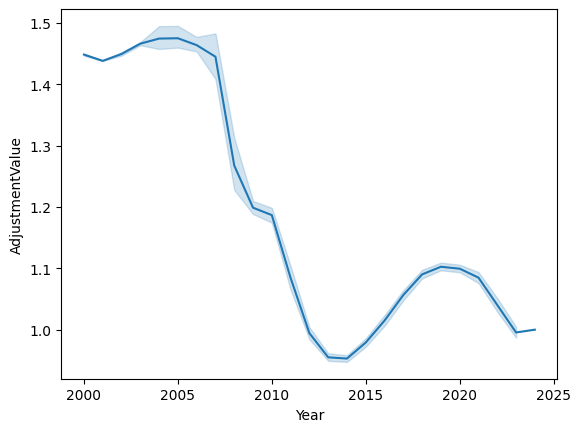

In [11]:
ax = sb.lineplot(data=AccomsCPI,x="Year",y="AdjustmentValue")

<Axes: xlabel='Year', ylabel='CPIvalue'>

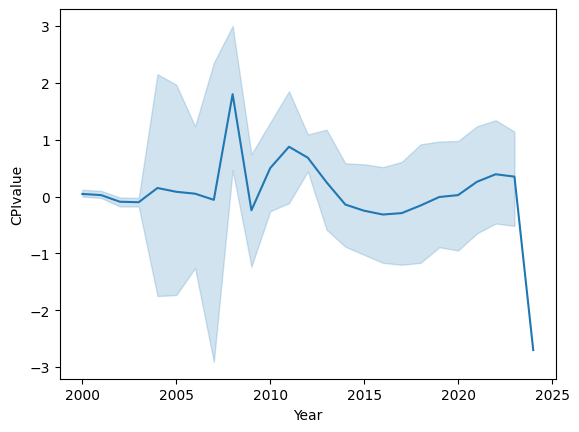

In [12]:
sb.lineplot(data=AccomsCPI,x="Year",y="CPIvalue")

In [13]:
merged_data = pd.merge(sorted_combined_data, AccomsCPI, on=['Year','Month'])
merged_data['AdjustmentValue'] = merged_data['AdjustmentValue'].fillna("NA")
merged_data

,Year,Month,town,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,CPIvalue,AdjustmentValue
0,2000,2,QUEENSTOWN,5 ROOM,04 TO 06,138.0,Model A,1996,526000.0,NULL,0.0,1.450914
1,2000,2,QUEENSTOWN,5 ROOM,04 TO 06,125.0,Standard,1977,470000.0,NULL,0.0,1.450914
2,2000,2,QUEENSTOWN,5 ROOM,01 TO 03,117.0,Standard,1978,435000.0,NULL,0.0,1.450914
3,2000,2,QUEENSTOWN,5 ROOM,13 TO 15,117.0,Standard,1978,470000.0,NULL,0.0,1.450914
4,2000,2,QUEENSTOWN,5 ROOM,19 TO 21,123.0,Standard,1976,435000.0,NULL,0.0,1.450914
...,...,...,...,...,...,...,...,...,...,...,...,...
628402,2024,1,HOUGANG,4 ROOM,01 TO 03,90.0,Model A,2003,495000.0,78 years 05 months,-2.7,1.000000
628403,2024,1,HOUGANG,4 ROOM,07 TO 09,94.0,Model A,2019,630000.0,94 years 11 months,-2.7,1.000000
628404,2024,1,HOUGANG,4 ROOM,01 TO 03,93.0,Model A,2018,528000.0,93 years 10 months,-2.7,1.000000
628405,2024,1,HOUGANG,4 ROOM,07 TO 09,93.0,Model A,2019,630000.0,94 years 08 months,-2.7,1.000000


In [14]:
# Adjust the sale price to today's cost
merged_data['resale_price_adjusted'] = merged_data['resale_price'] * merged_data['AdjustmentValue']

# Drop the unnecessary columns after adjustment
columns_to_drop = ['CPIvalue']
merged_data.drop(columns=[col for col in columns_to_drop if col in merged_data.columns], axis=1, inplace=True)

#changing "x" years and "y" months into x+(y/12) years ---> eg 4years 6 months = 4.5years 
merged_data['years'] = merged_data['remaining_lease'].str.extract(r'(\d+) years').astype(float)
merged_data['months'] = merged_data['remaining_lease'].str.extract(r'(\d+) months').astype(float)
merged_data['remaining_lease'] = merged_data['years'] + merged_data['months'] / 12
merged_data = merged_data.drop(['years', 'months'], axis=1)

#changing 7 to 9 floor into average of 8th floor
merged_data['lower_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,0]
merged_data['upper_storey'] = merged_data['storey_range'].str.extract(r'(\d+) TO (\d+)').astype(float).iloc[:,1]
merged_data['average_storey'] = (merged_data['lower_storey'] + merged_data['upper_storey']) / 2
columns_to_drop_final = ['lower_storey', 'upper_storey', 'storey_range', 'resale_price', 'AdjustmentValue']
merged_data = merged_data.drop(columns=[col for col in columns_to_drop_final if col in merged_data.columns], axis=1)

merged_data['remaining_lease'] = merged_data['remaining_lease'].fillna(np.nan)

merged_data




,Year,Month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price_adjusted,average_storey
0,2000,2,QUEENSTOWN,5 ROOM,138.0,Model A,1996,NaN,763180.858672,5.0
1,2000,2,QUEENSTOWN,5 ROOM,125.0,Standard,1977,NaN,681929.664593,5.0
2,2000,2,QUEENSTOWN,5 ROOM,117.0,Standard,1978,NaN,631147.668294,2.0
3,2000,2,QUEENSTOWN,5 ROOM,117.0,Standard,1978,NaN,681929.664593,14.0
4,2000,2,QUEENSTOWN,5 ROOM,123.0,Standard,1976,NaN,631147.668294,20.0
...,...,...,...,...,...,...,...,...,...,...
628402,2024,1,HOUGANG,4 ROOM,90.0,Model A,2003,78.416667,495000.000000,2.0
628403,2024,1,HOUGANG,4 ROOM,94.0,Model A,2019,94.916667,630000.000000,8.0
628404,2024,1,HOUGANG,4 ROOM,93.0,Model A,2018,93.833333,528000.000000,2.0
628405,2024,1,HOUGANG,4 ROOM,93.0,Model A,2019,94.666667,630000.000000,8.0


Goodness of Fit of Model on Train Dataset:
Explained Variance (R^2): 0.6131111560550183
Mean Squared Error (MSE): 12210415866.776316

Goodness of Fit of Model on Test Dataset:
Explained Variance (R^2): 0.6118864888398572
Mean Squared Error (MSE): 11919215457.279814



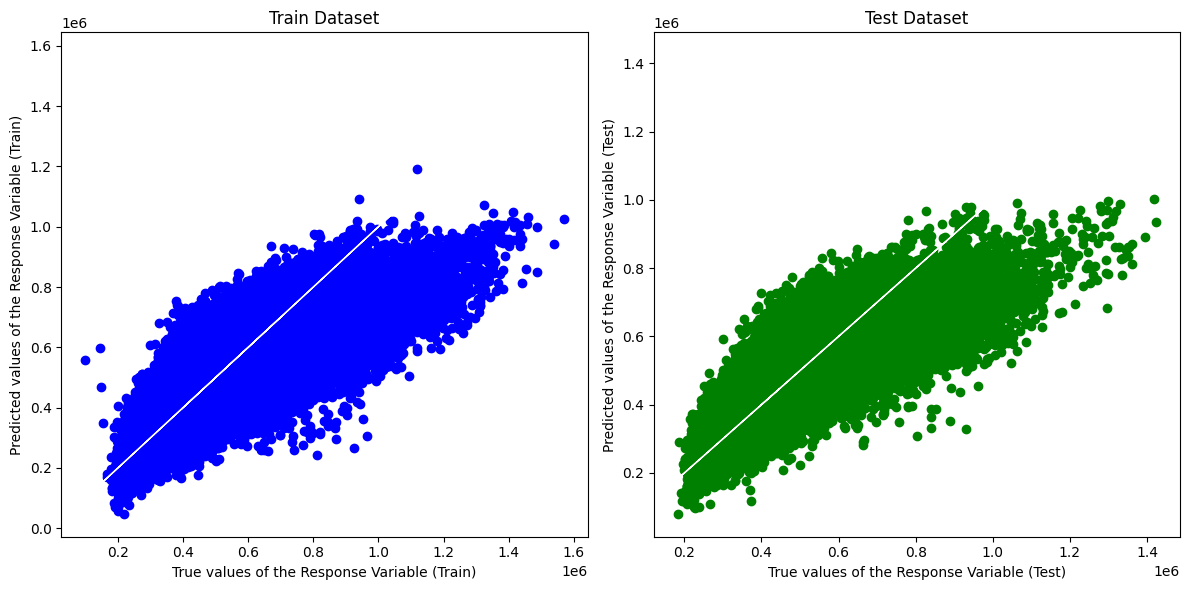

In [15]:


numericalData = pd.DataFrame(merged_data[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey', 'resale_price_adjusted']])

# Drop NaN values from both features and target variable
numericalData.dropna(subset=['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey', 'resale_price_adjusted'], inplace=True)
X = numericalData[['floor_area_sqm', 'lease_commence_date', 'remaining_lease', 'average_storey']]
y = numericalData['resale_price_adjusted']
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model Evaluation
print("Goodness of Fit of Model on Train Dataset:")
print("Explained Variance (R^2):", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE):", mean_squared_error(y_train, y_train_pred))
print()

print("Goodness of Fit of Model on Test Dataset:")
print("Explained Variance (R^2):", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_test_pred))
print()

# Plot the Predictions versus True values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, color="blue")
plt.plot(y_train, y_train, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Train)")
plt.ylabel("Predicted values of the Response Variable (Train)")
plt.title("Train Dataset")

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, color="green")
plt.plot(y_test, y_test, 'w-', linewidth=1)
plt.xlabel("True values of the Response Variable (Test)")
plt.ylabel("Predicted values of the Response Variable (Test)")
plt.title("Test Dataset")

plt.tight_layout()
plt.show()

In [16]:
numericalData.corr()


,floor_area_sqm,lease_commence_date,remaining_lease,average_storey,resale_price_adjusted
floor_area_sqm,1.000000,0.118556,0.125314,-0.012044,0.621624
lease_commence_date,0.118556,1.000000,0.989653,0.275887,0.364075
remaining_lease,0.125314,0.989653,1.000000,0.275345,0.334943
average_storey,-0.012044,0.275887,0.275345,1.000000,0.369148
resale_price_adjusted,0.621624,0.364075,0.334943,0.369148,1.000000


<Axes: >

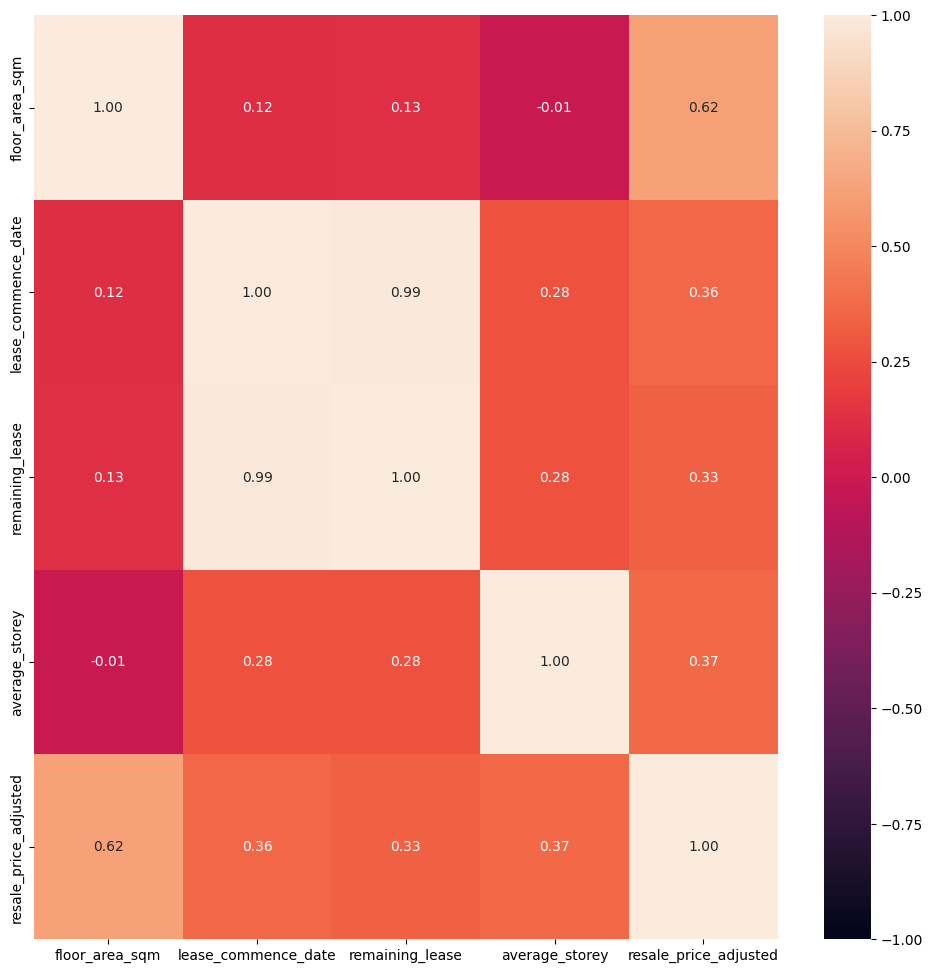

In [17]:
f = plt.figure(figsize=(12, 12))
sb.heatmap(numericalData.corr(), vmin = -1, vmax = 1, annot = True, fmt = ".2f")


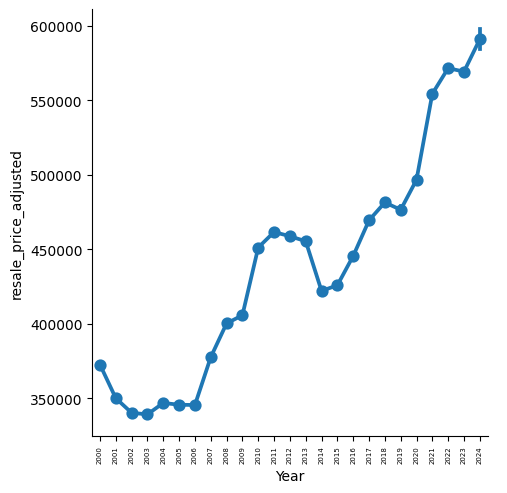

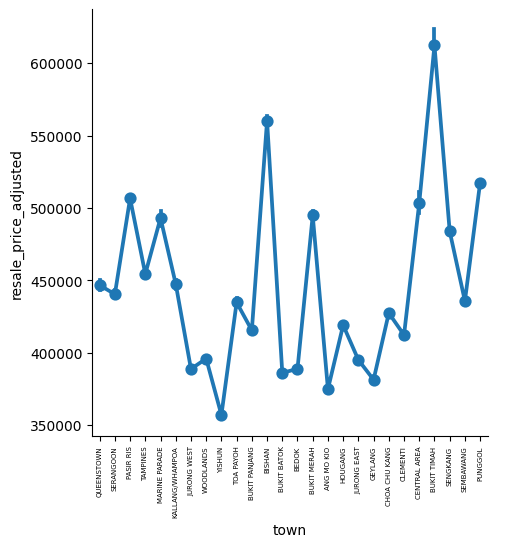

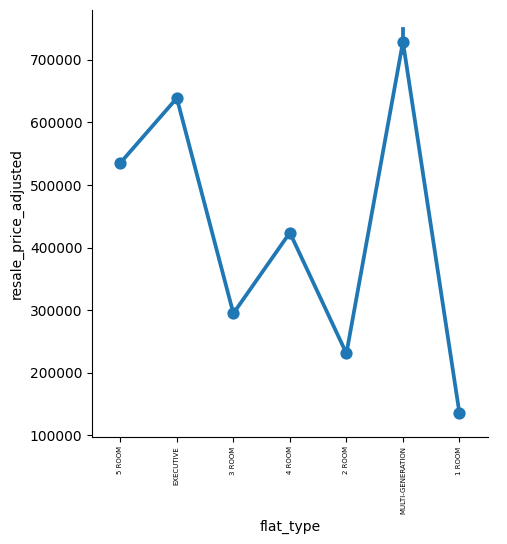

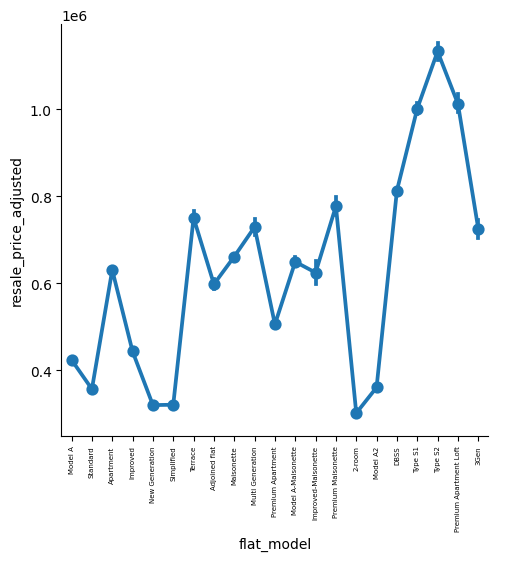

In [18]:
categoricaldata = pd.DataFrame(merged_data[['Year', 'town', 'flat_type', 'flat_model', 'resale_price_adjusted']])
for var in ['Year', 'town', 'flat_type', 'flat_model']:
    plot = sb.catplot(data=categoricaldata, x=var, y='resale_price_adjusted', kind = 'point')
    plot.set_xticklabels(fontsize=5,rotation = 90)  


In [22]:
merged_data.to_csv('merged_data.csv', index=False)

# Load data and split

In [20]:
train = merged_data
target = 'resale_price_adjusted'

# If the 'Set' column does not exist, create it to randomly assign rows to train, valid, and test sets.
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

# Get indices for each set.
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

print(train_indices, valid_indices, test_indices)

Index([     0,      2,      3,      6,      8,     10,     11,     12,     13,
           14,
       ...
       628397, 628398, 628399, 628400, 628401, 628402, 628403, 628404, 628405,
       628406],
      dtype='int64', length=502760) Index([     4,      5,      9,     22,     40,     45,     48,     50,     67,
           78,
       ...
       628265, 628274, 628310, 628331, 628337, 628350, 628365, 628373, 628393,
       628396],
      dtype='int64', length=62686) Index([     1,      7,     27,     28,     31,     33,     35,     47,     69,
           73,
       ...
       628285, 628321, 628334, 628338, 628341, 628342, 628348, 628352, 628359,
       628390],
      dtype='int64', length=62961)


# Simple preprocessing

Label encode categorical features and fill empty cells.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Assuming 'train' is your DataFrame.

# Initialize lists and dictionaries.
categorical_columns = []
categorical_dims = {}

# Process categorical columns.
for col in train.columns[train.dtypes == object]:
    print(col, train[col].nunique())
    l_enc = LabelEncoder()
    # Fill missing values with a placeholder string, 'VV_likely'.
    train[col] = train[col].fillna("VV_likely")
    # Transform the column with LabelEncoder.
    train[col] = l_enc.fit_transform(train[col].values)
    # Append the column name to the list of categorical columns.
    categorical_columns.append(col)
    # Store the number of unique values in the categorical_dims dictionary.
    categorical_dims[col] = len(l_enc.classes_)

# Process numerical columns.
# Note: You should only fill NaNs with the mean of the training set to prevent data leakage.
for col in train.columns[(train.dtypes == 'float64') | (train.dtypes == 'int64')]:
    # Calculate the mean from the training set only.
    mean_value = train.loc[train_indices, col].mean()
    # Fill missing values with the mean value.
    train.fillna({col: mean_value}, inplace=True)

# If 'remaining_lease' has NaNs, this is a special case because it's a float but with a lot of missing values.
# You might want to fill its NaNs separately with the mean or another relevant statistic from the training set.
if 'remaining_lease' in train.columns:
    mean_remaining_lease = train.loc[train_indices, 'remaining_lease'].mean()
    train.fillna({'remaining_lease': mean_remaining_lease}, inplace=True)

train


town 26
flat_type 7
flat_model 21
Set 3


,Year,Month,town,flat_type,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price_adjusted,average_storey,Set
0,2000,2,18,4,138.0,8,1996,74.689628,763180.858672,5.0,1
1,2000,2,18,4,125.0,17,1977,74.689628,681929.664593,5.0,1
2,2000,2,18,4,117.0,17,1978,74.689628,631147.668294,2.0,1
3,2000,2,18,4,117.0,17,1978,74.689628,681929.664593,14.0,1
4,2000,2,18,4,123.0,17,1976,74.689628,631147.668294,20.0,0
...,...,...,...,...,...,...,...,...,...,...,...
628402,2024,1,11,3,90.0,8,2003,78.416667,495000.000000,2.0,2
628403,2024,1,11,3,94.0,8,2019,94.916667,630000.000000,8.0,1
628404,2024,1,11,3,93.0,8,2018,93.833333,528000.000000,2.0,1
628405,2024,1,11,3,93.0,8,2019,94.666667,630000.000000,8.0,1


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628407 entries, 0 to 628406
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Year                   628407 non-null  int64  
 1   Month                  628407 non-null  int64  
 2   town                   628407 non-null  int64  
 3   flat_type              628407 non-null  int64  
 4   floor_area_sqm         628407 non-null  float64
 5   flat_model             628407 non-null  int64  
 6   lease_commence_date    628407 non-null  int64  
 7   remaining_lease        628407 non-null  float64
 8   resale_price_adjusted  628407 non-null  float64
 9   average_storey         628407 non-null  float64
 10  Set                    628407 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 52.7 MB


# Define categorical features for categorical embeddings

In [23]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

# Define your embedding sizes for categorical features. This could be based on the cardinality of the features
# or determined through experimentation. For example, a common heuristic is to take the 
# min(50, (category_count + 1) // 2), but here we just use predefined sizes.
cat_emb_dim = [min(50, (dim + 1) // 2) for dim in cat_dims]


# Network parameters

In [24]:
clf = TabNetRegressor(cat_dims=cat_dims, cat_emb_dim=cat_emb_dim, cat_idxs=cat_idxs)

/Users/kur0/Documents/Year1/sc1015_lab/SC1015_Mini_Proj/.mini/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


# Training

In [25]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices].reshape(-1, 1)

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices].reshape(-1, 1)

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices].reshape(-1, 1)

X_train

array([[2.00000000e+03, 2.00000000e+00, 1.80000000e+01, ...,
        1.99600000e+03, 7.46896278e+01, 5.00000000e+00],
       [2.00000000e+03, 2.00000000e+00, 1.80000000e+01, ...,
        1.97700000e+03, 7.46896278e+01, 5.00000000e+00],
       [2.00000000e+03, 2.00000000e+00, 1.80000000e+01, ...,
        1.97800000e+03, 7.46896278e+01, 2.00000000e+00],
       ...,
       [2.02400000e+03, 1.00000000e+00, 1.10000000e+01, ...,
        2.01800000e+03, 9.38333333e+01, 2.00000000e+00],
       [2.02400000e+03, 1.00000000e+00, 1.10000000e+01, ...,
        2.01900000e+03, 9.46666667e+01, 8.00000000e+00],
       [2.02400000e+03, 1.00000000e+00, 1.10000000e+01, ...,
        2.01900000e+03, 9.46666667e+01, 5.00000000e+00]])

In [26]:
max_epochs = 100 if not os.getenv("CI", False) else 2

In [27]:
from pytorch_tabnet.augmentations import RegressionSMOTE
aug = RegressionSMOTE(p=0.2)

In [28]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
    max_epochs=max_epochs,
    patience=50,
    batch_size=1024, virtual_batch_size=128,
    num_workers=5,
    drop_last=False,
    augmentations=aug, #aug
) 

In [ ]:
# Deprecated : best model is automatically loaded at end of fit
# clf.load_best_model()

preds = clf.predict(X_test)

y_true = y_test

test_score = mean_squared_error(y_pred=preds, y_true=y_true)

print(f"BEST VALID SCORE FOR dataset_name : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR dataset_name : {test_score}")

BEST VALID SCORE FOR dataset_name : 2078463756.848309
FINAL TEST SCORE FOR dataset_name : 2087643679.3250017


# Save model and load

In [ ]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [ ]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetRegressor()
loaded_clf.load_model(saved_filepath)

c:\Users\User\OneDrive - Nanyang Technological University\Desktop\NTU\Y1S1\SC1003- Intro to Computer Thinking\C Coding\SC1015_Mini_Proj\tabnet1\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [ ]:
loaded_preds = loaded_clf.predict(X_test)
loaded_test_mse = mean_squared_error(loaded_preds, y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_mse}")

FINAL TEST SCORE FOR census-income : 0.10537114846128602


In [ ]:
assert(test_score == loaded_test_mse)

# Global explainability : feat importance summing to 1

In [ ]:
clf.feature_importances_

array([9.77791451e-02, 6.13724158e-03, 1.26214851e-02, 1.62031754e-02,
       1.11614628e-01, 4.39594988e-01, 7.00270865e-03, 2.21551328e-02,
       2.42098249e-02, 4.74765422e-02, 7.87972700e-02, 6.09876806e-02,
       7.53701552e-02, 5.00226303e-05])

# Local explainability and masks

In [ ]:
explain_matrix, masks = clf.explain(X_test)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

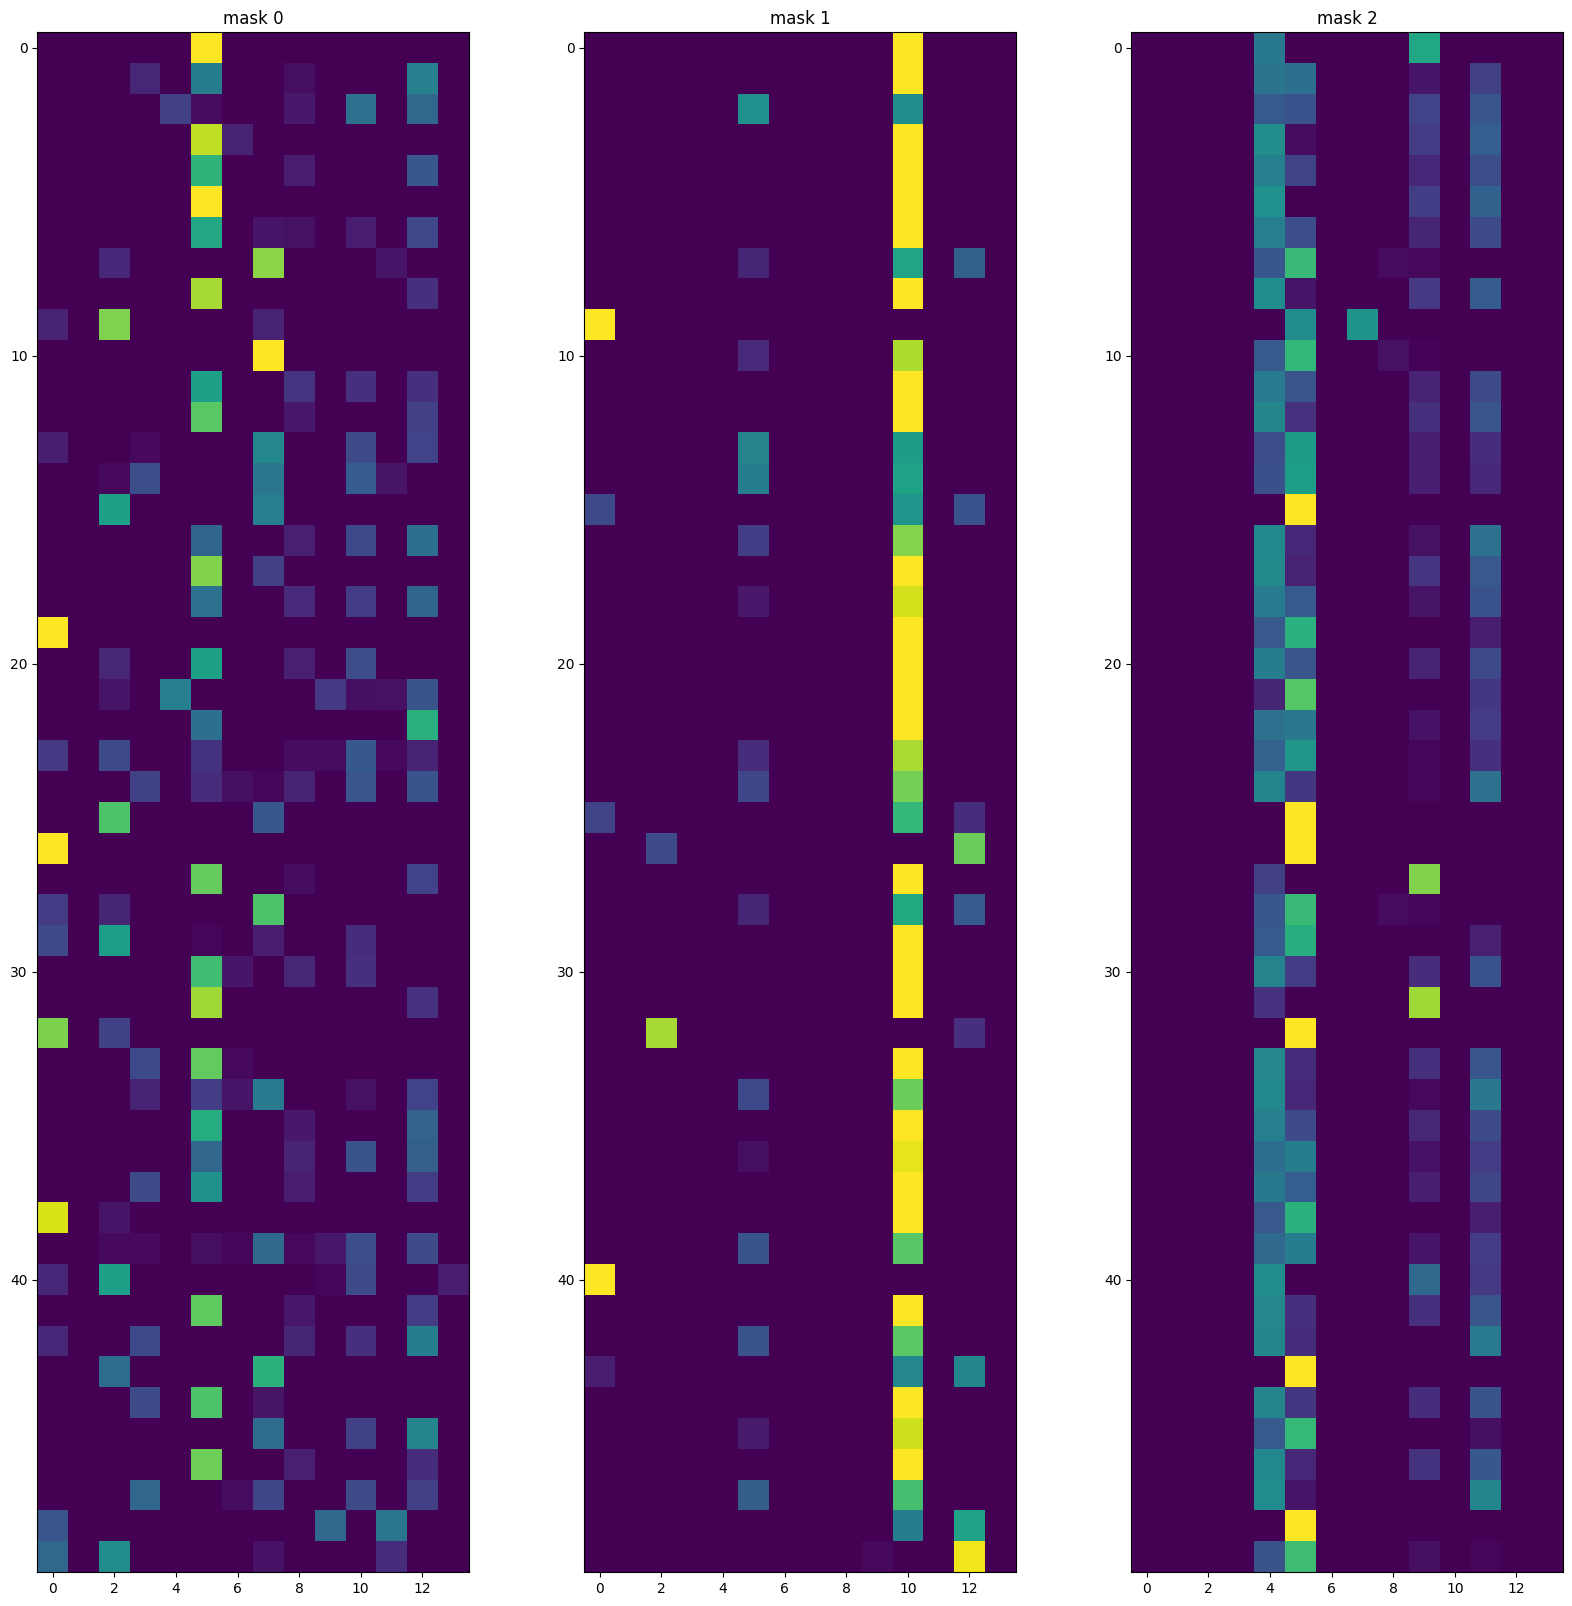

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")


# XGB

In [ ]:
from xgboost import XGBRegressor

clf_xgb = XGBRegressor(max_depth=8,
    learning_rate=0.1,
    n_estimators=1000,
    verbosity=0,
    silent=None,
    objective='reg:linear',
    booster='gbtree',
    n_jobs=-1,
    nthread=None,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.7,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,)

clf_xgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=40,
        verbose=10)

[0]	validation_0-rmse:0.46966


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-rmse:0.33042
[20]	validation_0-rmse:0.30299
[30]	validation_0-rmse:0.29676
[40]	validation_0-rmse:0.29432
[50]	validation_0-rmse:0.29357
[60]	validation_0-rmse:0.29379
[70]	validation_0-rmse:0.29397
[80]	validation_0-rmse:0.29466
[89]	validation_0-rmse:0.29509


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, nthread=None, num_parallel_tree=None, ...)

In [ ]:
preds = np.array(clf_xgb.predict(X_valid))
valid_auc = mean_squared_error(y_pred=preds, y_true=y_valid)
print(valid_auc)

preds = np.array(clf_xgb.predict(X_test))
test_auc = mean_squared_error(y_pred=preds, y_true=y_test)
print(test_auc)

0.08611793607844748
0.09051238654361735
